## Basic pyerrors example

Import pyerrors, as well as autograd wrapped numpy and matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyerrors as pe

In [2]:
plt.style.use('./base_style.mplstyle')
plt.rc('text', usetex=True)

We use numpy to generate some fake data

In [3]:
test_sample1 = np.random.normal(2.0, 0.5, 1000)
test_sample2 = np.random.normal(1.0, 0.1, 1000)

From this we can construct `Obs`, which are the basic object of `pyerrors`. For each sample we give to the obs, we also have to specify an ensemble/replica name. In this example we assume that both datasets originate from the same gauge field ensemble labeled 'ens1'.

In [4]:
obs1 = pe.Obs([test_sample1], ['ens1'])
obs2 = pe.Obs([test_sample2], ['ens1'])

We can now combine these two observables into a third one:

In [5]:
obs3 = np.log(obs1 ** 2 / obs2 ** 4)

`pyerrors` overloads all basic math operations, the user can work with these `Obs` as if they were real numbers. The proper resampling is performed in the background via automatic differentiation.

If we are now interested in the error of obs3, we can use the `gamma_method` to compute it and then print the object to the notebook

In [6]:
obs3.gamma_method()
print(obs3)

Obs[1.387(19)]


With print level 1 we can take a look at the integrated autocorrelation time estimated by the automatic windowing procedure.

In [7]:
obs3.print(1)

Result	 1.38669742e+00 +/- 1.94840399e-02 +/- 9.74201997e-04 (1.405%)
  t_int	 5.01998002e-01 +/- 4.47213596e-02 S = 2.00


As expected the random data from numpy exhibits no autocorrelation ($\tau_\text{int}\,\approx0.5$). It can still be interesting to have a look at the window size dependence of the integrated autocorrelation time

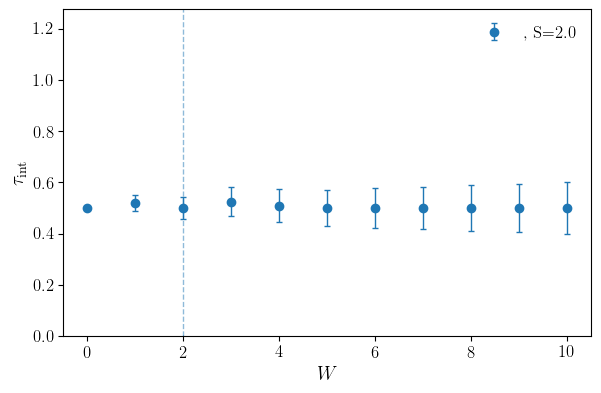

In [8]:
obs3.plot_tauint()

This figure shows the windowsize dependence of the integrated autocorrelation time. The red vertical line signalizes the window chosen by the automatic windowing procedure with $S=2.0$.
Choosing a larger windowsize would not significantly alter $\tau_\text{int}$, so everything seems to be correct here.

## Correlated data

We can now generate fake data with given covariance matrix and integrated autocorrelation times:

In [9]:
cov = np.array([[0.5, -0.2], [-0.2, 0.3]]) # Covariance matrix
tau = [4, 8] # Autocorrelation times
c_obs1, c_obs2 = pe.misc.gen_correlated_data([2.8, 2.1], cov, 'ens1', tau)

and once again combine the two `Obs` to a new one with arbitrary math operations

In [10]:
c_obs3 = np.sin(c_obs1 / c_obs2 - 1)
c_obs3.gamma_method()
c_obs3.print()

Result	 3.27194697e-01 +/- 1.79228480e+00 +/- 3.07835024e-01 (547.773%)
  t_int	 5.31748262e+00 +/- 1.57262234e+00 S = 2.00


This time we see a significant autocorrelation so it is worth to have a closer look at the normalized autocorrelation function (rho) and the integrated autocorrelation time

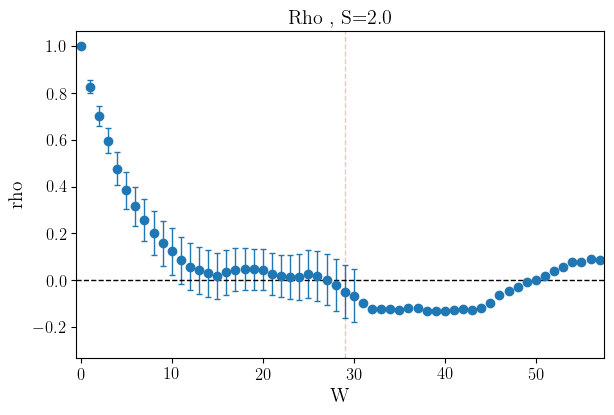

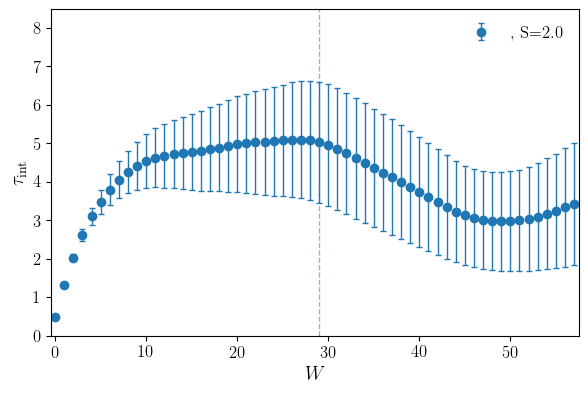

In [11]:
c_obs3.plot_rho()
c_obs3.plot_tauint()

We can now redo the error analysis and alter the value of S or attach a tail to the autocorrelation function to take into account long range autocorrelations

Result	 3.27194697e-01 +/- 1.88231459e+00 +/- 2.01855751e-01 (575.289%)
  t_int	 5.86511391e+00 +/- 2.16269625e+00 tau_exp = 20.00,  N_sigma = 1


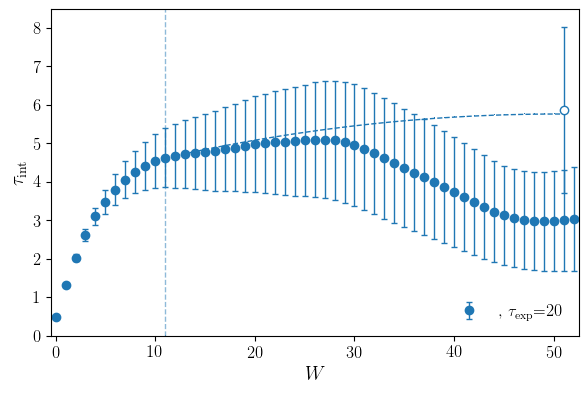

In [12]:
c_obs3.gamma_method(tau_exp=20)
c_obs3.print()
c_obs3.plot_tauint()

## Jackknife

For comparison and as a crosscheck, we can do a jackknife binning analysis. We compare the result for different binsizes with the result from the gamma method. Besides the more robust approach of the gamma method, it can also be shown that the systematic error of the error decreases faster with $N$ in comparison to the binning approach (see hep-lat/0306017)

Binning analysis:
Result:	 3.27194697e-01 +/- 1.30323584e+00 +/- 1.74847436e-01 (398.306%)
Result:	 3.27194697e-01 +/- 1.42921199e+00 +/- 3.13124657e-01 (436.808%)
Result:	 3.27194697e-01 +/- 1.36761713e+00 +/- 4.28131883e-01 (417.983%)


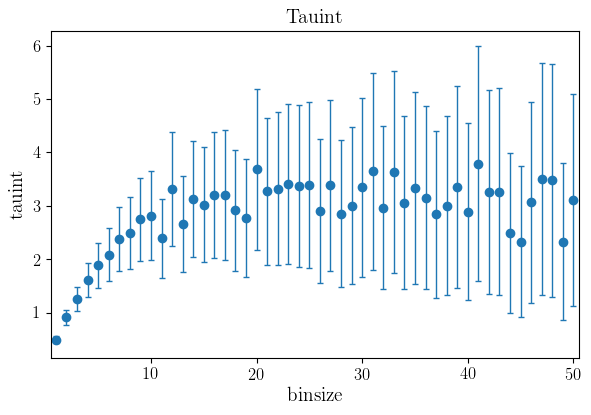

Result from the automatic windowing procedure for comparison:
Result	 3.27194697e-01 +/- 1.78414777e+00 +/- 2.73504675e-01 (545.286%)
  t_int	 5.26930916e+00 +/- 1.36902941e+00 S = 1.50
Result	 3.27194697e-01 +/- 1.79228480e+00 +/- 3.07835024e-01 (547.773%)
  t_int	 5.31748262e+00 +/- 1.57262234e+00 S = 2.00
Result	 3.27194697e-01 +/- 1.67905409e+00 +/- 3.16358031e-01 (513.167%)
  t_int	 4.66682386e+00 +/- 1.53936903e+00 S = 3.00


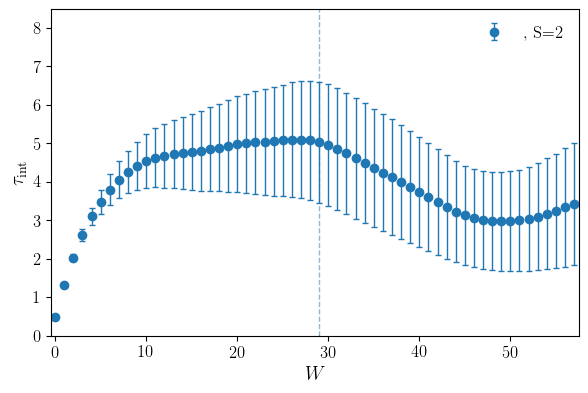

In [13]:
import pyerrors.jackknifing as jn
jack1 = jn.generate_jack(c_obs1, max_binsize=50)
jack2 = jn.generate_jack(c_obs2, max_binsize=50)
jack3 = jn.derived_jack(lambda x: np.sin(x[0] / x[1] - 1), [jack1, jack2])

print('Binning analysis:')
jack3.print(binsize=10)
jack3.print(binsize=25)
jack3.print(binsize=50)

jack3.plot_tauint()

print('Result from the automatic windowing procedure for comparison:')
c_obs3.gamma_method(S=1.5)
c_obs3.print()
c_obs3.gamma_method(S=2)
c_obs3.print()
c_obs3.gamma_method(S=3)
c_obs3.print()

c_obs3.gamma_method(S=2)
c_obs3.plot_tauint()

For this specific example the binned Jackknife procedure seems to underestimate the final error, the deduced intergrated autocorrelation time depends strongly on the chosen binsize. The automatic windowing procedure displayed for comparison gives more robust results for this example.